### Multiple output 

In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from lstm_support import normalize
from lstm_support import set_global_determinism
set_global_determinism()
from matplotlib.dates import DateFormatter

In [34]:
#data_test = np.array(pd.read_csv('sensor6_2022.csv')['height (m)'])
# dataset import
df =  pd.read_csv('sensor6_2021.csv')
dfz = df.drop(['time'],axis=1)
df2 = normalize(dfz)
x =df2[df2.columns[0]].to_numpy()
data_size = int(x.shape[0] * .80)
data_train = x[:data_size].flatten()
data_test = x[data_size:].flatten()
data_test.shape

(59,)

In [35]:
#train_test_split
def split_stage(series, h_step, f_step):
    x, y = list(), list()
    for i in range(len(series)):
        win_end_indx = i + h_step
        future_indx = win_end_indx + f_step
        if future_indx > len(series):
            break
        series_x, series_y = series[i:win_end_indx], series[win_end_indx:future_indx ]
        x.append(series_x)
        y.append(series_y)
    return np.array(x), np.array(y)

In [36]:
h_step = 4
f_step = 5
x_train, y_train = split_stage(data_train, h_step , f_step) 
y_train.shape

(227, 5)

In [37]:
n_features = 1
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
x_train.shape, y_train.shape

((227, 4, 1), (227, 5))

In [38]:
x_test, y_test = split_stage(data_test, h_step , f_step )
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
x_test.shape, y_test.shape

((51, 4, 1), (51, 5))

### MODEL 

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM, Bidirectional
from tensorflow.keras.utils import plot_model

In [40]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(150, activation='relu'), input_shape=(x_train.shape[1], n_features)))
model.add(Dense(y_test.shape[1]))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(x_train, y_train, epochs=40, batch_size= 70, validation_data=(x_test, y_test), verbose=0, shuffle=False)

In [41]:
y_pred = model(x_test)
#y_true = y_scaler.inverse_transform(y_pred)
y_pred.shape

TensorShape([51, 5])

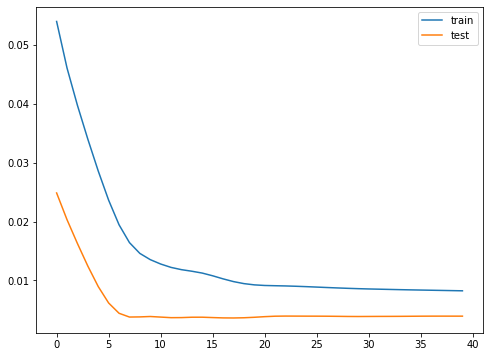

In [42]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Model evaluation 

In [43]:
def evaluate_model(y_test , y_pred):
    scores = []
    #scores for each day
    for i in range (y_test.shape[1]):
        mse = mean_squared_error(y_test[:,i], y_pred[:,i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    #scores for the whole prediction exercise
    overall_score = 0
    for row in range (y_test.shape[0]):
        for col in range (y_pred.shape[1]):
            overall_score = overall_score + (y_test[row,col]-y_pred[row,col])**2
    overall_score = np.sqrt(overall_score/(y_test.shape[0] * y_pred.shape[1]))
    return   scores

In [44]:
s = evaluate_model(y_test,y_pred)
s

[0.04323474273127149,
 0.0493646112287388,
 0.06048477351139922,
 0.07138891265934144,
 0.08119320756198226]

In [45]:
x = np.arange(1,f_step+1)
k = [0.0427, 0.0496, 0.0611, 0.0707, 0.0764]

In [52]:
u = y_pred[:, 4]
v = y_test[:,4]

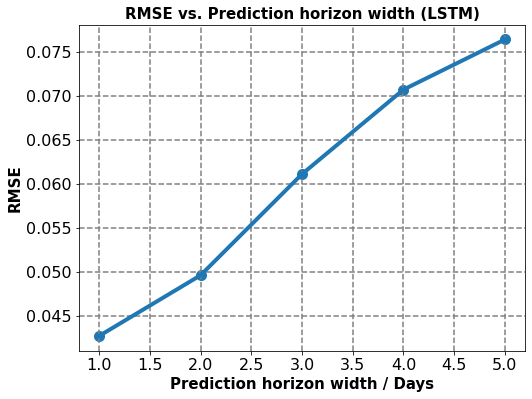

In [53]:
#Plot the output
fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (8,6)
fig.patch.set_facecolor('white')
plt.plot(x, k, linewidth=4)
plt.scatter(x, k, s=100)
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('RMSE vs. Prediction horizon width (LSTM)',fontsize=15,weight = 'bold')
ax.set_xlabel('Prediction horizon width / Days',fontsize=15,weight = 'bold')
ax.set_ylabel('RMSE',fontsize=15, weight = 'bold')
ax.tick_params(axis='both',labelsize=16)
ax.tick_params(axis = 'x', labelsize = 16)
ax.grid(True)
ax.set(facecolor = "white")
plt.savefig('LS1.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()

In [54]:
df2 = df.tail(len(y_test))
df2[['time']] = df2[['time']].apply(pd.to_datetime, format="%d/%m/%Y")

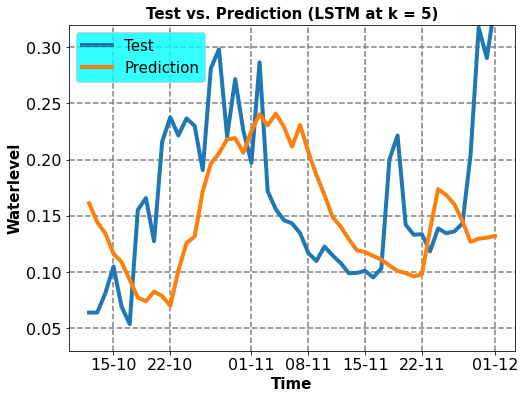

In [55]:
#Plot the output
plt.rcParams['figure.figsize'] = (8,6)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
Test, = plt.plot(df2['time'],v,linewidth=4, label='label1')
Prediction, = plt.plot(df2['time'], u, linewidth=4, label='label1')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('Test vs. Prediction (LSTM at k = 5)',fontsize=15,weight = 'bold')
ax.set_xlabel('Time',fontsize=15,weight = 'bold')
ax.set_ylabel('Waterlevel',fontsize=15, weight = 'bold')
ax.set_ylim(0.03,0.32)
ax.tick_params(axis='both',labelsize=16)
ax.tick_params(axis = 'x', labelsize = 16)
ax.grid(True)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend(["Test", "Prediction"], loc ="upper left", fancybox=True,facecolor='#01FFFF',prop={'size': 15,  'style': 'normal'})
ax.set(facecolor = "white")
plt.savefig('ls1.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()